## Experiment 2 - Notebook
- This notebook implements the experiment 2.
- In the experiment 2, we use SAM model in your original version and:
    - train a model for segment one of N seismic facies (espectialist model for a single facie)
    - segment 3 masks.
    - all segmentation is automatic, i.e, not used prompt encoder during finetune.
    - we execute a preprocess in images and label to get one facie at a time.

In [2]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
from typing import List, Optional, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap

import lightning as L
import torch
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from torchinfo import summary
from torch import nn

from minerva.models.finetune_adapters import LoRA
from minerva.models.nets.image.sam import Sam
from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform
from minerva.data.readers.reader import _Reader
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline

from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime
from lightning.pytorch.loggers import CSVLogger

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.6.0+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 2
CUDA Device Name: NVIDIA RTX A6000


## Variables

In [4]:
# f3
# model_name = "SAM_ViT_B_f3"
# height, width = 255, 701 # f3
# train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# parihaka
model_name = "SAM_ViT_B_parihaka"
height, width = 1006, 590 # parihaka
train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

# checkpoints SAM
checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth" # vit_b
# checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_h_4b8939.pth" # vit_h

# parameters
vit_model = 'vit-b'
filter_type=None # il_ to filter inlines, xl_ to filter crosslines and None to no apply filter
num_classes = 3
facie = 1 # from 0 to 5
num_epochs = 20
ratio = 1.0
batch_size = 1
debug=False # if true, show debug in cell "Debug"
gpu_index = 0

## Transform

In [5]:
class Padding(_Transform):
    def __init__(self, target_h_size: int, target_w_size: int):
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        pad_h = max(0, self.target_h_size - h)
        pad_w = max(0, self.target_w_size - w)
        if len(x.shape) == 2:
            padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
            padded = np.expand_dims(padded, axis=2)
            padded = torch.from_numpy(padded).float()
        else:
            padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            padded = torch.from_numpy(padded).float()

        padded = np.transpose(padded, (2, 0, 1))
        return padded

## Custom Dataset for SAM

In [6]:
class DatasetForSAM(SimpleDataset):
    def __init__(
            self, 
            readers: List[_Reader], 
            transforms: Optional[_Transform] = None,
            select_facie:int=0
    ):
        super().__init__(readers, transforms)
        self.select_facie = select_facie # pode ser: 0 (facie mais escura), a 5 (facie mais clara)

        assert (
            len(self.readers) == 2
        ), "DatasetForSAM requires exactly 2 readers (image your label)"
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        data_readers = []
        for reader, transform in zip(self.readers, self.transforms):
            sample = reader[index]
            if transform is not None:
                sample = transform(sample)
            data_readers.append(sample)

        # normalize and add 3 channels
        image = data_readers[0]
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        image = (image * 255).clamp(0, 255).to(torch.uint8)
        label = data_readers[1]

        # Gera uma máscara binária apenas para a fácie selecionada
        binary_mask = (label == self.select_facie).to(torch.uint8)

        data = {
            'image': image,
            'label': binary_mask,
            'original_size': (int(image.shape[1]), int(image.shape[2])),
            'class_id': self.select_facie
        }

        return data

## Data Module

In [7]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        select_facie:int=0,
        batch_size: int = 1,
        data_ratio: float = 1.0,
        filter_type: str = None,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.select_facie = select_facie
        self.batch_size = batch_size
        self.data_ratio = data_ratio

        if filter_type not in (None, "il_", "xl_"):
            raise ValueError(f"filter_type must be 'il_', 'xl_', or None, but got '{filter_type}'")
        self.filter_type = filter_type

        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")

            # applying filter for get only inline or crossline
            if self.filter_type:
                # to images
                train_img_reader.files = [
                    f for f in train_img_reader.files 
                    if f.name.startswith(self.filter_type) and f.name.lower().endswith((".tiff", ".tif"))
                ]
                # to labels
                train_label_reader.files = [
                    f for f in train_label_reader.files 
                    if f.name.startswith(self.filter_type) and f.name.lower().endswith((".png"))
                ]

            # applying ratio
            num_train_samples = int(len(train_img_reader) * self.data_ratio)
            if num_train_samples < len(train_img_reader):
                indices = random.sample(range(len(train_img_reader)), num_train_samples)
                train_img_reader = [train_img_reader[i] for i in indices]
                train_label_reader = [train_label_reader[i] for i in indices]
                
            train_dataset = DatasetForSAM(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
                select_facie=self.select_facie
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")
            val_dataset = DatasetForSAM(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
                select_facie=self.select_facie
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")
            test_dataset = DatasetForSAM(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
                select_facie=self.select_facie
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")
    
    def custom_collate_fn(self, batch):
        """
        Custom collate function for DataLoader to return a list of dictionaries.
        """
        return batch 

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            collate_fn=self.custom_collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.custom_collate_fn
        )

## Init data module

In [8]:
data_module = DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    transforms=Padding(height, width),
    filter_type=filter_type,
    batch_size=batch_size,
    select_facie=facie,
    data_ratio=ratio
)

## Debug

In [9]:
if debug:
    def get_train_dataloader(data_module):
        data_module.setup("fit")
        return data_module.train_dataloader()

    print("Total batches: ", len(get_train_dataloader(data_module)))

    train_batch = next(iter(get_train_dataloader(data_module)))
    print(f"Train batch image (X) shape: {train_batch[0]['image'].shape}")
    print(f"Train batch label (Y) shape: {train_batch[0]['label'].shape}")
    print(f"Train batch label (original_size) shape: {train_batch[0]['original_size']}")

    for idx, batch in enumerate(get_train_dataloader(data_module)):
        print(f"Batch {idx}:")
        print(f"Tipo do batch: {type(batch)}")
        print(f"Tamanho do batch: {len(batch)}")  # Deve ser igual ao batch_size
        print("Estrutura do primeiro item do batch:")
        # print(batch[0])  # Exibe o primeiro dicionário do batch
        print(f"Shape da imagem no primeiro item: {batch[0]['image'].shape}")
        
        print(20*'-')

        print(f"Train batch image (X) shape: {batch[0]['image'].shape}")
        print(f"Train batch label (Y) shape: {batch[0]['label'].shape}")
        print(f"Train batch label (original_size) shape: {batch[0]['original_size']}")
        break  # Para após o primeiro batch

In [10]:
if debug:
    print(f"O Batch (de tamanho {len(train_batch)}) possui: {train_batch[0]['image'].shape[0]} canais, {train_batch[0]['image'].shape[1]} altura e {train_batch[0]['image'].shape[2]} largura.")

In [11]:
if debug:
    # Obtendo a imagem e a label do batch
    image = train_batch[0]['image'].squeeze(0)  # Remover a dimensão do batch (1, 3, 1006, 590) -> (3, 1006, 590)
    label = train_batch[0]['label'].squeeze(0)  # Remover a dimensão do batch (1, 1, 1006, 590) -> (1, 1006, 590)

    # Transformando para formato adequado para matplotlib
    image = image.permute(1, 2, 0).cpu().numpy()  # (3, 1006, 590) -> (1006, 590, 3)
    label = label.squeeze(0).cpu().numpy()  # (1, 1006, 590) -> (1006, 590)

    # Plotando a imagem e a label
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Imagem original
    axes[0].imshow(image)
    axes[0].set_title("Imagem")
    axes[0].axis('off')

    # Label (provavelmente uma máscara ou rótulo binário)
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title("Label")
    axes[1].axis('off')

    plt.show()

## Init model

In [15]:
model = Sam(
    vit_type=vit_model,
    checkpoint=checkpoint_path,
    num_multimask_outputs=num_classes, # default: 3
    iou_head_depth=num_classes, # default: 3
    # apply_freeze=apply_freeze,
    # apply_adapter=apply_adapter,
    train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=num_classes)},
    multimask_output=False,
    # loss_fn=DiceCELoss() # if multimask_output is false
    loss_fn=nn.BCEWithLogitsLoss()
)

model

Prompt Encoder freeze!


Sam(
  (loss_fn): BCEWithLogitsLoss()
  (model): _SAM(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (act): GELU(approximate='none')
          )
        )
      )
      (neck): Sequential(
        (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): LayerNorm2d()
        (2): Conv2d(256, 256

In [16]:
def calculate_model_size(model: torch.nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = total_params * 4  # 4 bytes por parâmetro
    size_in_mb = size_in_bytes / (1024 ** 2)
    return size_in_mb

print("Peso em MB: ", calculate_model_size(model))
summary(model)

Peso em MB:  357.57244873046875


Layer (type:depth-idx)                                       Param #
Sam                                                          --
├─BCEWithLogitsLoss: 1-1                                     --
├─_SAM: 1-2                                                  --
│    └─ImageEncoderViT: 2-1                                  3,145,728
│    │    └─PatchEmbed: 3-1                                  590,592
│    │    └─ModuleList: 3-2                                  85,147,136
│    │    └─Sequential: 3-3                                  787,456
│    └─PromptEncoder: 2-2                                    --
│    │    └─PositionEmbeddingRandom: 3-4                     --
│    │    └─ModuleList: 3-5                                  (1,024)
│    │    └─Embedding: 3-6                                   (256)
│    │    └─Sequential: 3-7                                  (4,684)
│    │    └─Embedding: 3-8                                   (256)
│    └─MaskDecoder: 2-3                                   

## Train

In [17]:
current_date = datetime.now().strftime("%Y-%m-%d")

# Define o callback para salvar o modelo com base no menor valor da métrica de validação
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # Métrica para monitorar
    # save_last=True,
    dirpath="./checkpoints", # Diretório onde os checkpoints serão salvos
    filename=f"sam_experiment_2_{ratio}_using_facie_{facie}-{model_name}-{current_date}-{{epoch:02d}}-{{val_loss:.2f}}", # Nome do arquivo do checkpoint
    save_top_k=1, # Quantos melhores checkpoints salvar (no caso, o melhor)
    mode="min", # Como a métrica deve ser tratada (no caso, 'min' significa que menor valor de val_loss é melhor)
)

logger = CSVLogger("logs", name="sam")

trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    devices=[gpu_index],
    logger=logger,
    callbacks=[checkpoint_callback],
)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Seed set to 0
/usr/local/lib/python3.10/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/sam/version_12 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_12
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_12/run_2025-03-03-12-43-20ba9950c5e4374d39b5262e94a0025e2a.yaml



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0      | train
1 | model   | _SAM              | 93.7 M | train
------------------------------------------------------
93.7 M    Trainable params
6.2 K     Non-trainable params
93.7 M    Total params
374.942   Total estimated model params size (MB)
239       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([1, 1006, 590])) must be the same as input size (torch.Size([1, 1, 1006, 590]))

## Test

In [ ]:
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_1/run_2025-02-22-12-48-279ac913e40b444872820dbae4b5141f4e.yaml
Testing DataLoader 0: 100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.7056908011436462     │
│      test_mIoU_epoch      │     0.746991753578186     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_1/run_2025-02-22-12-48-279ac913e40b444872820dbae4b5141f4e.yaml


[{'test_loss_epoch': 0.7056908011436462, 'test_mIoU_epoch': 0.746991753578186}]

## Predict

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_1/run_2025-02-22-12-48-279ac913e40b444872820dbae4b5141f4e.yaml
Predicting DataLoader 0: 100%|██████████| 200/200 [00:16<00:00, 11.96it/s]
Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/notebooks/logs/sam/version_1/run_2025-02-22-12-48-279ac913e40b444872820dbae4b5141f4e.yaml


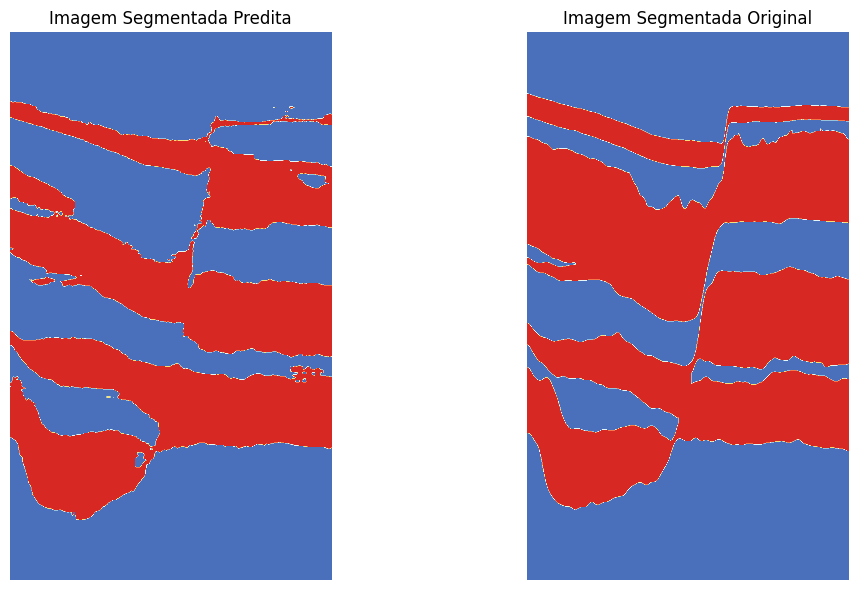

In [ ]:
# Definir o cmap para a imagem segmentada
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

# Criar o subplot com duas colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primeira imagem - Predição original
preds = pipeline.run(data=data_module, task="predict")
image1 = torch.argmax(preds[9][0]['masks_logits'], dim=1)
axes[0].imshow(image1.squeeze().numpy(), cmap=label_cmap)
axes[0].set_title("Imagem Segmentada Predita")
axes[0].axis("off")

# Segunda imagem - Predição com DataLoader
data_module.setup("predict")
pred_module = iter(data_module.predict_dataloader())

# Iterando para pegar o 9º elemento
for i, batch in enumerate(pred_module):
    if i == 9:
        pred_9 = batch  # Pega o batch de predição
        break

# Segunda imagem - Máscara segmentada da predição
image2 = pred_9[0]['label']
axes[1].imshow(image2.squeeze().numpy(), cmap=label_cmap)
axes[1].set_title("Imagem Segmentada Original")
axes[1].axis("off")

plt.tight_layout()
plt.show()